In [1]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example

from dm_control.locomotion.walkers import rodent
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

#viewer
from dm_control import viewer

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

#other sources
from dm_control.locomotion.examples import basic_rodent_2020 as br

In [2]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
matplotlib.rcParams['animation.ffmpeg_path'] = r"C:\Tools\ffmpeg-master-latest-win64-gpl\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"  # Windows 示例
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
env2=br.rodent_maze_forage
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())
np.random.seed(42)

In [3]:
class WPipe:
    """A 90-degree bent pipe with customizable segment lengths, thickness, and color."""
    def __init__(self, length1, length2, radius, rgba):
        """
        Initialize the bent pipe.

        Args:
            length1 (float): Length of the first straight segment.
            length2 (float): Length of the second straight segment.
            radius (float): Radius (thickness) of the pipe.
            rgba (list): Color and transparency of the pipe in [R, G, B, A] format.
        """
        self.model = mjcf.RootElement()

        # Defaults
        self.model.default.geom.type = 'cylinder'
        self.model.default.geom.rgba = rgba

        # First segment
        self.segment1 = self.model.worldbody.add('body',name='W_pipe')
        self.segment1.add('geom', fromto=[0, 0, 0, 0, 0, length1], size=[radius])

        # Bend (90-degree turn)
        self.bend = self.segment1.add('body', pos=[0, 0, length1])
        self.bend.add('geom',type='sphere', size=[radius])
        self.bend.add('geom', fromto=[0, 0, 0, -length2, 0 , 0], size=[radius])

class OPipe:
    """A 90-degree bent pipe with customizable segment lengths, thickness, and color."""
    def __init__(self, length1, length2, radius, rgba):
        """
        Initialize the bent pipe.

        Args:
            length1 (float): Length of the first straight segment.
            length2 (float): Length of the second straight segment.
            radius (float): Radius (thickness) of the pipe.
            rgba (list): Color and transparency of the pipe in [R, G, B, A] format.
        """
        self.model = mjcf.RootElement()

        # Defaults
        self.model.default.geom.type = 'cylinder'
        self.model.default.geom.rgba = rgba

        # First segment
        self.segment1 = self.model.worldbody.add('body',name='O_pipe')
        self.segment1.add('geom', name='Op1',fromto=[0, 0, 0, 0, 0, length1], size=[radius])

        # Bend (90-degree turn)
        self.bend = self.segment1.add('body', pos=[0, 0, length1])
        self.bend.add('geom',name='Op2',type='sphere', size=[radius])
        self.bend.add('geom',name='Op3', fromto=[0, 0, 0, -length2, 0 , 0], size=[radius])
        self.bend.add('geom',name='Op4', fromto=[-length2, 0, 0, -1.4*length2, 0 , 0], size=[1.5*radius])
        
#print(pipe.model.to_xml_string())查看mjcf模型的xml字符串


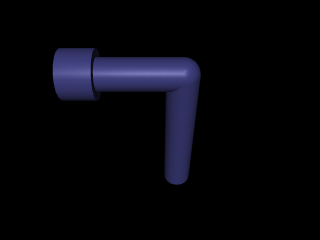

In [4]:
pipe = OPipe(length1=1.0, length2=0.5, radius=0.1, rgba=[0.5, 0.5, 1.0, 1.0])
physics = mjcf.Physics.from_mjcf_model(pipe.model)
PIL.Image.fromarray(physics.render())

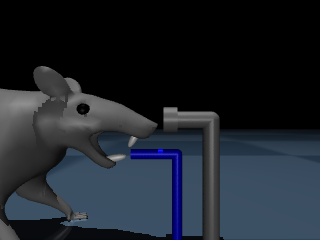

In [5]:
arena = mjcf.RootElement()  #声明根节点
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid) #添加地板
'''for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2]) #添加光源'''
arena.worldbody.add(
  'camera',
  name='fixed_camera_1',  # 摄像头名称
  pos=[0.14, -0.17, 0.07],        # 摄像头的位置 (x, y, z)
  quat=[0.707, 0.707, 0, 0]     # 摄像头的朝向（四元数，默认朝向 z 轴）
)
  
walker = rodent.Rat(torque_actuators= True, foot_mods=True)


p1=WPipe(length1=0.05, length2=0.027, radius=0.003, rgba=[0.0, 0.0, 1.0, 1.0])
p2=OPipe(length1=0.07, length2=0.02, radius=0.005, rgba=[0.5, 0.5, 0.5, 1.0])

spawn_site = arena.worldbody.add('site', pos=(0.15,0,0), group=3)
spawn_site.attach(p1.model)
spawn_site = arena.worldbody.add('site', pos=(0.17,0,0), group=3)
spawn_site.attach(p2.model)

spawn_site = arena.worldbody.add('site', pos=(0,0,0), group=3)
spawn_site.attach(walker.mjcf_model)
  
physics = mjcf.Physics.from_mjcf_model(arena)

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.geomgroup[2] = 0 

physics.model.opt.timestep = 0.002
PIL.Image.fromarray(physics.render(scene_option=scene_option,camera_id='fixed_camera_1'))
#PIL.Image.fromarray(physics.render(scene_option=scene_option))

In [6]:
from scipy.interpolate import pchip_interpolate
def generate_smooth_oscillation():
    total_points = 501
    

    t_control = np.array([0.0, 0.15, 0.2,  
                         0.3, 0.4, 0.5, 0.6, 0.7, 0.8,  
                         0.85, 1.0])  
    
    y_control = np.array([-0.3, -0.1, 0.1, 
                          0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 
                          -0.2, -0.3]) 
    
    t_highres = np.linspace(0, 1, 2000)  

    y_highres = pchip_interpolate(t_control, y_control, t_highres)

    t_final = np.linspace(0, 1, total_points)
    y_final = pchip_interpolate(t_highres, y_highres, t_final)
    
    return t_final, y_final

# 生成曲线
t, y = generate_smooth_oscillation()
y = np.append(y, -0.3)

In [7]:
Op_geom=['unnamed_model_1/Op1',
         'unnamed_model_1/Op2',
         'unnamed_model_1/Op3',
         'unnamed_model_1/Op4']

In [14]:
def demo_show(RatSignal,OpSignal_1,OpSignal_2,cmd_duration=1,framerate=60,camera='fixed_camera_1'):
  duration = cmd_duration*len(RatSignal)    # (seconds)
  
  physics.reset()
  frames = []
  t_step=-1
  
  while physics.data.time < duration:
    if physics.data.time - t_step >= cmd_duration:
      if OpSignal_1[t_step+1]==1:
        for geom in Op_geom:  
          physics.named.model.geom_rgba[geom] =  [1.0, 0.0, 0.0, 1.0] #red
      elif OpSignal_2[t_step+1]==1:
        for geom in Op_geom:  
          physics.named.model.geom_rgba[geom] =  [0.0, 1.0, 0.0, 1.0] #blue
      else:
        for geom in Op_geom:  
          physics.named.model.geom_rgba[geom] =  [0.5, 0.5, 0.5, 1.0] #gray
      if RatSignal[t_step+1]==1:
        act=1
        sub_act=0
      else:
        act=0
    if act==1:
      physics.named.data.qpos['walker/mandible']=y[sub_act]
      sub_act+=1
    else:
      physics.named.data.qpos['walker/mandible']=-0.3
    t_step=int(physics.data.time)
    #print('time:{}'.format(physics.data.time))
    #print(physics.named.data.qpos)
    physics.step()

    if len(frames) < (physics.data.time) * framerate:
      pixels = physics.render(camera_id=camera,scene_option=scene_option)
      frames.append(pixels)
  return display_video(frames, framerate)


In [15]:
demo_show(RatSignal=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_1=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_2=[0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1])